# GABAergic Synaptic Physiology

One of the primary focuses for our lab is examining the properties of various connections (called synapses) between populations of cells within the brain. Although we know a great deal about the anatomical connectivity of the brain (i.e. what cell populations send and receive connections from other cell populations), we know far less about the actual functional characteristics of those connections. An understanding of the synaptic physiology at the single cell level, which is where we do most of work, is an important step in understanding how the larger circuits in the brain work as well as how those circuits can be disrupted in various neurological disorders. 

The work presented below focuses on one synapse between two nuclei - a nucleus in the brainstem refered to as the PPN, and another nucleus (the SNc) composed of the cells that die in Parkinson's disease. In particular, I present work examining the GABAergic input from the PPN to the SNc (GABA is the primary inhibitory signaling molecule in the brain). 

In [3]:
from glob import glob
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
sys.path.append('../../neurphys/neurphys/')
import pv_import as pvi
import synaptics as syn
import utilities as util

%matplotlib inline

# GABA IV

While we often like to think of neurons as being the biological equivalent to a transistor (and, at least in their output, they do act very much like a logic gate), in truth each neuron is really a small computational unit. It's job is to sum the various signals it receives and to decide whether that information is worth passing along or not. Some of those signals act to push the cell towards passing that information along, while others act to inhibit that transfer. 

A neuron stores electrical charge by creating a separation of charged particles (primarily K+, Na+, Cl-, Ca2+ ions) across its membrane (i.e. some of those charged particles have a higher concentration inside the cell vs. outside, and vice versa). When a neuron transmits information, it does so by discharging the energy it has stored up through the creation of this charge separation. 

This is done by the opening of channels (pores, basically little holes) in the membrane, allowing those ions to flow across the membrane (producing a current). The direction of the flow of the different ions is determined 1. by the concentration across the membrane of each specific ion and 2. the total charge separation across the membrane (termed "membrane potential", Vm). 

In any one neuron there are many different types of channels, including ones that are activated by the binding of a neurotransmitter, such as GABA. One property of these channels that we often study is termed the reversal potential (ERev) - i.e. the specific membrane potential at which the flow of ions goes from having an inhibitory effect on the cell to having an excitatory effect on the cell (or vice versa). 

We determine ERev experimentally by measuring the current flow across the membrane while the cell is held at different membrane potentials. In the experiment presented below SNc neurons are held at different potentials, and then a GABAergic synapse is activated, producing a current. The amplitude of that current is plotted as a function of the membrane potential the cell is held at (creating an current vs. voltage, or I-V, plot). 

In [4]:
folders = glob('./data/GABA_IV/*')
folders.sort()
folders

['./data/GABA_IV/08.14.15_Cell2-IV-001',
 './data/GABA_IV/08.14.15_Cell3-IV-001',
 './data/GABA_IV/08.14.15_Cell4-IV-001',
 './data/GABA_IV/09.15.16_Cell4-IV-001',
 './data/GABA_IV/09.15.16_Cell5-IV-001',
 './data/GABA_IV/09.15.16_Cell6-IV-001']

In [5]:
Vms = [-80, -70, -65, -60, -55, -50, -45, -40, -35, -30, -20, -10, 0, 10, 20]
# correction for liquid junction potential
ljp = 5.9
Vms = [Vm - 5.9 for Vm in Vms]
iv_df = pd.DataFrame(index=Vms)
iv_df.index.names = ['Vms']

The analysis itself is fairly straightforward. During each sweep a different voltage step (in the order indicated above) is applied to the cell. At the same time, a single stimulus pulse is applied to the input cells, producing a current in the cell that is being recorded. We simply want the peak of that current. At some point, the current will switch directions, which we can see in a sign change in the current amplitude.

In [6]:
for folder in folders:
    df = pvi.import_folder(folder)['voltage recording']
    sweeps = df.index.levels[0]
    peak_vals = []
    for sweep in sweeps:
        bsl_data = util.baseline(df.ix[sweep], 5.0, 6.0)
        peak_min = util.find_peak(bsl_data, 6.5, 6.6, 'min')['Peak Amp'].values[0]
        peak_max = util.find_peak(bsl_data, 6.5, 6.6, 'max')['Peak Amp'].values[0]

        if abs(peak_min) > abs(peak_max):
            peak_vals.append(peak_min)
        else:
            peak_vals.append(peak_max)
    peak_vals = [peak_val / abs(peak_vals[0]) for peak_val in peak_vals]
    cell_id = os.path.split(folder)[-1]
    iv_df[cell_id] = peak_vals

Because there is a great deal of variabilty across cells in terms of how any one cell responds to the synaptic stimulus (i.e. some cells show a very large response, while others show much smaller responses), we normalize within each cell to the response recorded during the -80 mV (-85.9 mV adjusted) step, allowing us to generate an average IV for all of the recorded cells.  

In [7]:
iv_df

,08.14.15_Cell2-IV-001,08.14.15_Cell3-IV-001,08.14.15_Cell4-IV-001,09.15.16_Cell4-IV-001,09.15.16_Cell5-IV-001,09.15.16_Cell6-IV-001
Vms,,,,,,
-85.9,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
-75.9,-0.639470,-0.728361,-0.645795,-0.869976,-1.118004,-0.890914
-70.9,-0.452830,-0.690992,-0.299001,-0.600938,-0.659577,-0.677553
-65.9,-0.271643,-0.503107,-0.453542,-0.660236,-0.768676,-0.502738
-60.9,0.142826,-0.365143,-0.188821,-0.436526,-0.441230,-0.338271
-55.9,-0.121037,-0.269161,0.148830,-0.317651,-0.247668,-0.219213
-50.9,0.398809,0.136877,0.180890,-0.187854,-0.230101,0.125085
-45.9,0.597627,0.359301,0.428078,0.144277,0.168979,0.280801
-40.9,0.819089,0.523537,0.567024,0.343180,0.413187,0.458799


In [8]:
avg_iv = iv_df.mean(axis=1)
iv_sem = iv_df.std(axis=1) / 6

model = LinearRegression()
model.fit(X=np.array(Vms).reshape(15,1), y=avg_iv.values)
preds = model.predict(np.array(Vms).reshape(15,1))

The current flow through a channel can be modeled as a linear relationship, as described by Ohm's law (V = IR). Simply put, the voltage across the membrane is proportional to the current flowing through a resistor (i.e. the channel). In our case, we are holding the membrane potential at a constant value, and examing the size of the current as a function of that voltage (i.e. I = V / R, where R is essentially constant). 

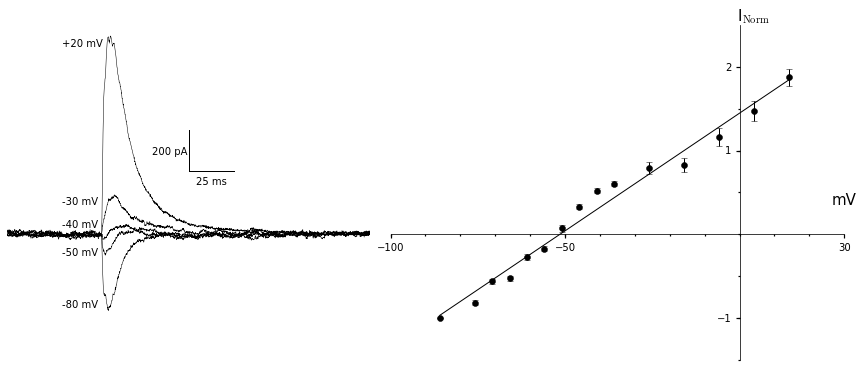

In [9]:
fig = plt.figure(figsize = (15,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.25], wspace=0.05)

########################################################
# Plot example traces
########################################################
ax1 = plt.subplot(gs[0])
df = pvi.import_folder(folders[1])['voltage recording']
sweep_list = ['Sweep0001', 'Sweep0006', 'Sweep0007', 'Sweep0009', 'Sweep0015']
for sweep in sweep_list:
    bsl_data = util.baseline(df.ix[sweep], 6.2, 6.45)
    sub_data = bsl_data[(bsl_data.Time >= 6.45) & (bsl_data.Time <= 6.65)]
    ax1.plot(sub_data.Time, sub_data.Primary, 'k', linewidth=0.5)

# cleanig up fig, add labels 
for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.plot([6.55, 6.575], [300, 300], 'k')
ax1.plot([6.55, 6.55], [300, 500], 'k')
ax1.text(6.554, 240, '25 ms')
ax1.text(6.53, 380, '200 pA')
ax1.text(6.48, 900, '+20 mV')
ax1.text(6.48, 145, '-30 mV')
ax1.text(6.48, 33, '-40 mV')
ax1.text(6.48, -100, '-50 mV')
ax1.text(6.48, -350, '-80 mV')
ax1.set_ylim(-600, 1000)

########################################################
# Plot IV
########################################################
ax2 = plt.subplot(gs[1])
ax2.plot(Vms, avg_iv, 'ko')
ax2.errorbar(Vms, avg_iv, yerr=iv_sem.values, 
            linestyle="None", ecolor='k')
ax2.plot(Vms, preds, 'k')
# hide top and right axes
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.tick_params(which='both', top='off', right='off')

# x-axis formatting
ax2.spines['left'].set_position('zero')
ax2.spines['left'].set_linewidth(0.75)
ax2.set_xticks([-100, -50, 30])
ax2.get_xaxis().set_tick_params(which="both", direction="out", 
                               width=1.2)
ax2.set_xticks(range(-100,30,10), minor=True)
ax2.set_xlabel('mV', fontsize=15)
ax2.xaxis.set_label_coords(1, 0.5)
ax2.set_xlim(-100, 30)

# y-axis formatting
ax2.spines['bottom'].set_position('zero')
ax2.spines['bottom'].set_linewidth(0.75)
ax2.set_yticks([-2, -1, 1, 2])
ax2.set_yticks([x*0.5 for x in range(-3, 4)], 
              minor=True)
ax2.get_yaxis().set_tick_params(which="both", direction="out", 
                               width=1.2)
ax2.set_ylabel('I$_\mathrm{Norm}$', 
              fontsize=15, rotation=0)
ax2.yaxis.set_label_coords(0.8 ,1)
ax2.set_ylim(-1.5, 2.5)

plt.show()

**(Left)** Example GABA currents recorded at different membrane potentials. Notice that in this cell the current reverses somewhere between -50 mV and -40 mV (-55.9 mV and -45.9 mV adjusted). 

**(Right)** IV plot of average normalized current amplitudes (+/- SEM) from 6 cells, fitted with a simple linear regression. 

In [10]:
x_intercept = model.intercept_ / model.coef_ * -1
r2 = r2_score(avg_iv.values, preds)
print("ERev: {:0.2f} mV, R2: {:0.4f}".format(x_intercept[0], r2))

ERev: -51.44 mV, R2: 0.9800


Based one the straight-line equation for the fitted linear regression, ERev for this channel is calculated as -51.44 mV. GABA receptors primarily conduct the ion chloride (Cl-) to produce a current. From the published literature we know that ERev for chloride in these cells is approximated -56 mV, which is very close to our calculated ERev for the channels studied in this experiment. 

With regards to the bigger picture, knowing ERev for a particular channel let's us predict how activating that channel will affect the overall activity of the cell. For these particular receptors, we now know that at membrane potentials above approximately -50mV, GABA will inhibit activity in these cells, but at more negative potentials it may actually act to excite them. 

# GABA Receptor Pharmacology

Membrane channels are large complexes of proteins. The structure of those protein complexes are what give the channel its properties (such as what type of ion(s) it can conduct, or if it is a ligand-gated channel like GABA receptors, what kind of molecules can bind to and activate the channel). 

GABA receptors are pentameric structures - meaning that they are composed of five subunits. Within the brain there are a variety of GABA subunits expressed by cells. Depending on which subunits are expressed by a cell, and how those subunits form together to make a particular GABA receptor (i.e. in what ratio the different subunits exist within the receptor), the receptor will have different properties.   

As part of our goal to understand how synaptic activity affects a cell's function, we want to know what particular subunits are expressed at different synapses. One way to achieve this is to use pharmacological agents that are selective for specific subunits. For example, benzodiazepines (e.g. Valium, Zolpidem, etc.) act by increasing GABA activity in the brain. For a particular GABA receptor to be affected by a benzo, however, it must express a certain combination of subunits.

In the presented experiment below we test two drugs - Zolipdem and DS2 - that are selective for different receptor subunits. Our output measures are current amplitude as well as the decay time constant (tau) for the measured current. 

In [11]:
folders = glob('./data/GABA_pharm/09.23*')
folders

['./data/GABA_pharm/09.23.15_Cell2-Control-001',
 './data/GABA_pharm/09.23.15_Cell2-GBZ-001',
 './data/GABA_pharm/09.23.15_Cell2-Wash-on-001']

These experiments all follow a similar pattern: 
1. Take a series of recording that serve as a control
2. Apply the drug
3. Take a series of recordings with drug applied (wash-on)
4. To validate that we are indeed looking at a GABA current, we wash on a GABA antagonist (Gabazine, GBZ)

The current is evoked in the same way as described above for the IV experiment (i.e. a single stimulus pulse)

A subsection of sweeps are taken, since the drug applications occurs while the recording is taking place. 
The bulk the the analysis work is done by the analyze_current function in the synaptics module put together as part of our lab's suit of analysis tools. 

In [12]:
##################################
# Zolpidem
##################################
zol_ctrl = pvi.import_folder(folders[0])['voltage recording']
zol_wash = pvi.import_folder(folders[-1])['voltage recording'].ix['Sweep0010': 'Sweep0014']
zol_gbz = pvi.import_folder(folders[1])['voltage recording'].ix['Sweep0003': 'Sweep0008']

zol_dfs = [zol_ctrl, zol_wash, zol_gbz]
zol_dfs = [df.groupby(level='Sweep').apply(util.baseline, 2.4, 2.9)
           for df in zol_dfs]
zol_avg_dfs = [df.groupby(level="Index").mean()
               for df in zol_dfs]

(zol_ctrl_peak, zol_ctrl_tau), (zol_wash_peak, zol_wash_tau) = [syn.analyze_current(df, 2.4, 2.9, 
                                                                                    3.0, 3.5, "max", 
                                                                                    calc_tau=True) 
                                                                for df in zol_avg_dfs[:2]]

In [13]:
folders = glob('./data/GABA_pharm/09.02*')
folders

['./data/GABA_pharm/09.02.15_Cell3-control-001',
 './data/GABA_pharm/09.02.15_Cell3-GBZ-001',
 './data/GABA_pharm/09.02.15_Cell3-wash-on-001']

In [14]:
##################################
# DS2
##################################
ds2_ctrl = pvi.import_folder(folders[0])['voltage recording'].ix['Sweep0001':'Sweep0004']
ds2_wash = pvi.import_folder(folders[-1])['voltage recording'].ix['Sweep0003':'Sweep0005']
ds2_gbz = pvi.import_folder(folders[1])['voltage recording'].ix['Sweep0003': 'Sweep0005']

ds2_dfs = [ds2_ctrl, ds2_wash, ds2_gbz]
ds2_dfs = [df.groupby(level='Sweep').apply(util.baseline, 5.0, 6.4)
           for df in ds2_dfs]
ds2_avg_dfs = [df.groupby(level="Index").mean()
               for df in ds2_dfs]

(ds2_ctrl_peak, ds2_ctrl_tau), (ds2_wash_peak, ds2_wash_tau) = [syn.analyze_current(df, 5.0, 6.5, 
                                                                                    6.5, 7.0, 
                                                                                    "max", calc_tau=True) 
                                                                for df in ds2_avg_dfs[:2]]

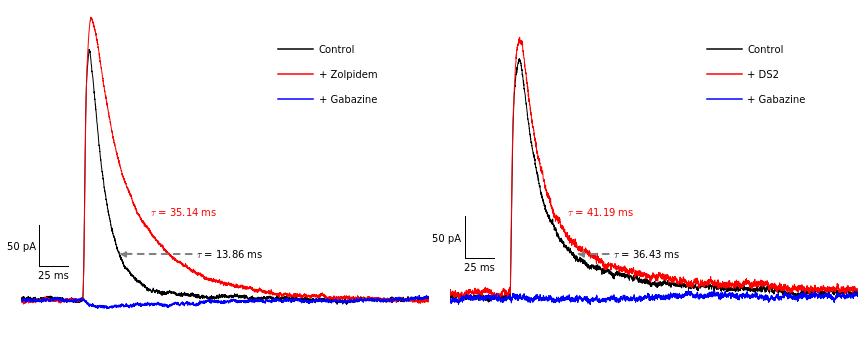

In [15]:
fig = plt.figure(figsize = (15,6))
gs = gridspec.GridSpec(1, 2, wspace=0.05)
colors = ['k', 'r', 'b']
##################################
# Zolpidem example trace plot
##################################
ax1 = plt.subplot(gs[0])
x = [3.17, 3.2]
y = [300, 300]
x_text = 3.205
y_text = 295
labels = ['Control', '+ Zolpidem', '+ Gabazine']
for color, label, df in zip(colors,labels, zol_avg_dfs):
    sub_df = df[(df.Time >= 2.95) & (df.Time <= 3.3)]
    ax1.plot(sub_df.Time, sub_df.Primary, color)
    ax1.plot(x, y, color, linewidth=1.5)
    ax1.text(x_text, y_text, label)
    y = [y[0] - 30, y[1] - 30]
    y_text -= 30

for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.plot([2.965, 2.990], [40, 40], 'k')
ax1.plot([2.965, 2.965], [40, 90], 'k')
ax1.text(2.964, 25, '25 ms')
ax1.text(2.938, 60, '50 pA')
ax1.text(3.06, 100, r'$\tau$ = {:0.2f} ms'.format(zol_wash_tau), color='r')
ax1.annotate(r'$\tau$ = {:0.2f} ms'.format(zol_ctrl_tau), xy=(3.032, 55),
                xytext=(3.1,50),
                arrowprops=dict(arrowstyle="-|>, head_width=0.25, head_length=0.5", 
                                linestyle='dashed', lw=2, color='gray'))
##################################
# DS2 example trace plot
##################################
ax2 = plt.subplot(gs[1])
x = [6.67, 6.7]
y = [300, 300]
x_text = 6.705
y_text = 295
labels = ['Control', '+ DS2', '+ Gabazine']
for color, label, df in zip(colors, labels, ds2_avg_dfs):
    sub_df = df[(df.Time >= 6.45) & (df.Time <= 6.8)]
    ax2.plot(sub_df.Time, sub_df.Primary, color)
    ax2.plot(x, y, color, linewidth=1.5)
    ax2.text(x_text, y_text, label)
    y = [y[0] - 30, y[1] - 30]
    y_text -= 30

for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.plot([6.463, 6.488], [50, 50], 'k')
ax2.plot([6.463, 6.463], [50, 100], 'k')
ax2.text(6.462, 35, '25 ms')
ax2.text(6.435, 70, '50 pA')
ax2.text(6.55, 100, r'$\tau$ = {:0.2f} ms'.format(ds2_wash_tau), color='r')
ax2.annotate(r'$\tau$ = {:0.2f} ms'.format(ds2_ctrl_tau), xy=(6.557, 55),
                xytext=(6.59,50),
                arrowprops=dict(arrowstyle="-|>, head_width=0.25, head_length=0.5", 
                                linestyle='dashed', lw=2, color='gray'))    
plt.show()

**(Left)** Example average traces before (black) and after (red) zolipidem application. Notice the substantial increase in decay time as. Application of gabazine (blue) abolishes the current, confirming this is a GABA current.

**(Right)** Example average traces before and after DS2 treatment. Here there is essentially no effect on either current peak or decay. Again, gabazine abolishes the current. 

In [21]:
zol_peak_change = (zol_wash_peak['Peak Amp'].values[0] - 
                   zol_ctrl_peak['Peak Amp'].values[0]) / zol_ctrl_peak['Peak Amp'].values[0] * 100
zol_tau_change = (zol_wash_tau - zol_ctrl_tau) / zol_ctrl_tau * 100

ds2_peak_change = (ds2_wash_peak['Peak Amp'].values[0] - 
                   ds2_ctrl_peak['Peak Amp'].values[0]) / ds2_ctrl_peak['Peak Amp'].values[0] * 100
ds2_tau_change = (ds2_wash_tau - ds2_ctrl_tau) / ds2_ctrl_tau * 100

print("Zolpidem (% Change) - Tau: {:0.2f}%, Amplitude: {:0.2f}%".format(zol_tau_change, zol_peak_change))
print("DS2 (% Change) - Tau: {:0.2f}%, Amplitude: {:0.2f}%".format(ds2_tau_change, ds2_peak_change))

Zolpidem (% Change) - Tau: 153.45%, Amplitude: 12.81%
DS2 (% Change) - Tau: 13.04%, Amplitude: 8.96%


### Summary

The zolipdem result is in line with the known mechanism of benzopiazepines, which increase GABAergic activity in the brain by increasing channel open time (i.e. increasing decay time). This implies that the GABA receptors at this particular synapse have the necessary subunits to bind and be affected by benzodiazepines. 

In contrast, the lack of an effect from DS2 application indicates that these receptors lack the particular subunit neccessary for DS2 to bind and have an effect.

Overall this gives us some insight into the composition of the GABA receptors at this synapse, which helps us understand how and why activation of this synapses will affect the overall activity of these cells. 